# PC Lab 5: Resampling Methods for Model Evaluation
---

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import pc5

## 1. Introduction

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/2880px-K-fold_cross_validation_EN.svg.png" width=500>

This tutorial is about an important tool for evaluating how accurate your model will perform in practice: _Resampling methods_ are an dispensable tool in modern statistics and involve repeatedly drawing samples from a training set and refitting a model of interest on each sample in order to obtain additional information about
the fitted model. 

For example, in order to estimate the variability of a linear regression fit, we can repeatedly draw different samples from the training data, fit a linear regression to each new sample, and then examine the
extent to which the resulting fits differ. Such an approach may allow us to obtain information that would not be available from fitting the model only once using the original training sample. 

Resampling approaches can be computationally expensive, because they involve fitting the same statistical method multiple times using different subsets of the training data. However, due to recent advances in computing
power, the computational requirements of resampling methods generally are not prohibitive. In this PC lab, we discuss two of the most commonly used resampling methods, _cross-validation_ and nested cross-validation.


We again first load the necessary files for this PC-lab:

In [4]:
!wget https://raw.githubusercontent.com/tfmortie/mlmust/main/05_evaluation/pc5.py
!wget https://raw.githubusercontent.com/tfmortie/mlmust/main/05_evaluation/promoters.csv

('promoters.csv', <http.client.HTTPMessage at 0x16a627c10>)

## 2. Data exploration: A simple promoter library

The dataset used for the first exercise is a simpe [E. coli promoter database](https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/promoter-gene-sequences/promoters.names) that contains a set of both promoter regions and non-promoter regions. A promoter region is the DNA sequence upstream of genes to which the RNA polymerase binds before the transcription of genes is initiated.

<img src="https://ib.bioninja.com.au/_Media/sections-of-a-gene_med.jpeg" width=500>

<div class="alert alert-success">

<b>EXERCISE 2.1</b>: **Load in the data and explore. Use _pd.Series.value_counts()_ to evaluate the empirical distribution of the labels. The data is stored in promoters.csv**
</div>  

In [5]:
df_data = pd.read_csv("promoters.csv")
df_data.head()

,True,S10,agtatgtataatgcgcgggcttgtcgt
0,True,AMPC,tgtcgttacaatctaacgcatcgccaa
1,True,AROH,ttttgttatcatgctaaccacccggcg
2,True,DEOP2,agtagatgttagaatactaacaaactc
3,True,LEU1_TRNA,aaccactagaatgcgcctccgtggtag
4,True,MALEFG,tataaagaaactagagtccgtttaggt


**We see the first column is not used to identify column names**. Hence, we can just load the dataframe without the header by means of setting <code>header=None<code>.

In [6]:
df_data = pd.read_csv("promoters.csv", header=None)
df_data.head()

,0,1,2
0,True,S10,agtatgtataatgcgcgggcttgtcgt
1,True,AMPC,tgtcgttacaatctaacgcatcgccaa
2,True,AROH,ttttgttatcatgctaaccacccggcg
3,True,DEOP2,agtagatgttagaatactaacaaactc
4,True,LEU1_TRNA,aaccactagaatgcgcctccgtggtag


Now evaluate the distribution of the 2 labels, using the built-in pandas function <code>pd.Series.value_counts()</code>. Is our dataset balanced?

In [7]:
df_data[0].value_counts(dropna=False)

0
True     53
False    53
Name: count, dtype: int64

In [8]:
len(df_data)

106

**We aee that we are working with a balanced dataset, there are no invalid entries in the column for labels.**

<div class="alert alert-success">

<b>EXERCISE 2.2</b>: **Create the features and labels for the model. Create your own features by using insights from the previous practical or use _pc5.CreateDummyNucleotideFeatures()_. In order to transform the labels, take a look at _sklearn.preprocessing.LabelEncoder_.**
</div>  

In [10]:
X = pc5.CreateDummyNucleotideFeatures(df_data[2], 27)
#get numpy array from pandas dataframe
X = X.values

y = LabelEncoder().fit_transform(df_data[0])

**As given in the docstring: for the features, a pandas DataFrame object is returned. To transform into Numpy array, use the <code>pd.DataFrame.values</code> function.**

## 3. Cross-validation

In this section we will elaborate on two specific questions that are strongly related to cross-validation. Both questions stem from the fact that we aim to build models with a high predictive power, based on a finite dataset.
 - **Question 1**: Given a relatively small dataset, how can we use the promoter dataset as efficiently as possible, to construct a model that  optimally predicts the existence of a promoter region in the prokaryotic DNA?
 - **Question 2**: How can we decide which machine learning method should be preferred to predict the presence of a promoter region?


### Question 1: k-fold cross-validation

K-fold cross-validation is a resampling technique that is often used in machine learning in order to assess the generalization performance of a machine learning model. It consists of partitioning a dataset into k equally-sized folds or subsets. Next, the model is trained and validated k times, each time using a different fold as the evaluation set and the remaining k-1 folds as training set. The final performance metric is often computed as the average of the performance scores obtained in each iteration, providing a more reliable estimate of the model's generalization ability.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*AAwIlHM8TpAVe4l2FihNUQ.png" width=600>

<div class="alert alert-success">

<b>EXERCISE 3.1</b>: **Write out code that performs cross-validation for a k-nearest neighbor model by using the [_StratifiedKFold()_](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) function in Scikit-learn. Use four folds and determine the optimal number of neighbors that maximize accuracy. What is the optimal number of neighbors?**
</div>  

Maximum Accuracy with 8 neighbors


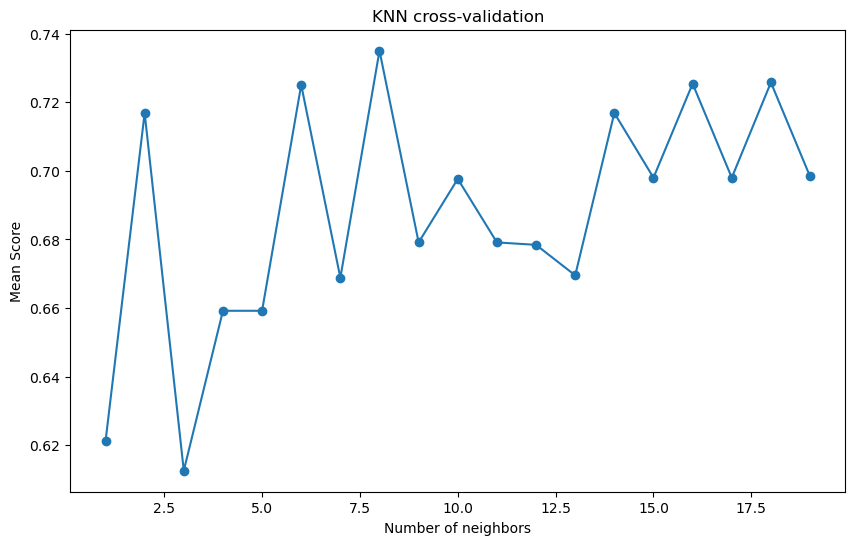

In [15]:
fold_scores = []
# define space to iterate over
space = np.arange(1,20)
# define folds
folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for tr_idx, tu_idx in folds.split(X,y):
    hyper_scores = [] # store scores for each hyperparameter (number of neighbors in thiss case)
    for hyper in space:
        knn = KNeighborsClassifier(n_neighbors=hyper)
        knn.fit(X[tr_idx],y[tr_idx]) #fit calssifier on training data
        score = knn.score(X[tu_idx], y[tu_idx]) # evaluate score on leave-out data
        hyper_scores.append(score)
    fold_scores.append(hyper_scores)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(space, np.mean(fold_scores, axis=0), "-o") # use the mean of the scores for each hyperparameter
ax.set_xlabel("Number of neighbors")
ax.set_ylabel("Mean Score")
ax.set_title("KNN cross-validation")

print(f"Maximum Accuracy with {space[np.argmax(np.mean(fold_scores, axis=0))]} neighbors")

<div class="alert alert-success">

<b>EXERCISE 3.2</b>: **Copy your code from the previous exercise below. Replace the plot function with the _ax.errorbar()_ function and add the variances of the scores displayed as vertical bars. In what range do they lie?**
</div>  

Text(0.5, 1.0, 'KNN cross-validation with error bars')

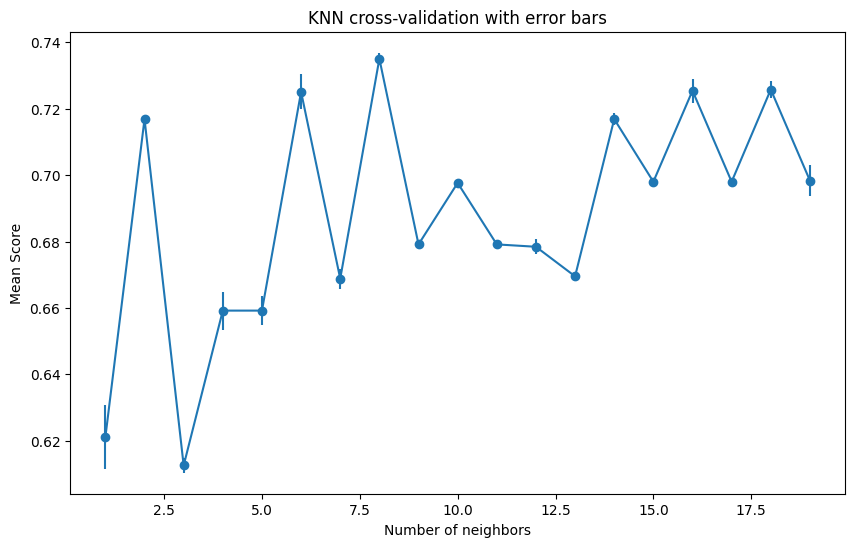

In [18]:
fold_scores = []
# define space to iterate over
space = np.arange(1,20)
# define folds
folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for tr_idx, tu_idx in folds.split(X,y):
    hyper_scores = []
    for hyper in space:
        knn = KNeighborsClassifier(n_neighbors=hyper)
        knn.fit(X[tr_idx],y[tr_idx])
        score = knn.score(X[tu_idx], y[tu_idx])
        hyper_scores.append(score)
    fold_scores.append(hyper_scores)
fig, ax = plt.subplots(1,1,figsize=(10,6))

# ax.plot(space, np.mean(fold_scores, axis=0))
ax.errorbar(space,np.mean(fold_scores,axis=0),np.var(fold_scores,axis=0),fmt='-o')
ax.set_xlabel("Number of neighbors")
ax.set_ylabel("Mean Score")
plt.title("KNN cross-validation with error bars")

In [16]:
np.var(fold_scores, axis=0)

array([9.56972752e-03, 3.84914692e-04, 2.17936543e-03, 5.70142998e-03,
       4.32968787e-03, 5.24447854e-03, 3.02503632e-03, 1.82628388e-03,
       3.93031509e-04, 9.60194114e-04, 3.93031509e-04, 2.27511851e-03,
       4.17001485e-04, 1.75665680e-03, 7.18338325e-04, 3.61134954e-03,
       3.24672689e-05, 2.66383796e-03, 4.64522914e-03])

<div class="alert alert-success">

<b>EXERCISE 3.3</b>: **Evaluate the variance of the performance measure for an increasing amount of folds. Use as many folds as possible. Applying cross-validation with n-1 folds is also known as leave-one-out cross-validation (LOOCV). Note that using the _StratifiedKFold()_ function does not allow you to perform LOOCV, since it restricts the user to $n/2$ folds, in order to preserve the percentage of sample per class. Use the [_LeaveOneOut_](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) class in Scikit-learn instead. Think about the (dis)advantages of using few or many folds.**
</div> 

Optimal number of neighbors: 2


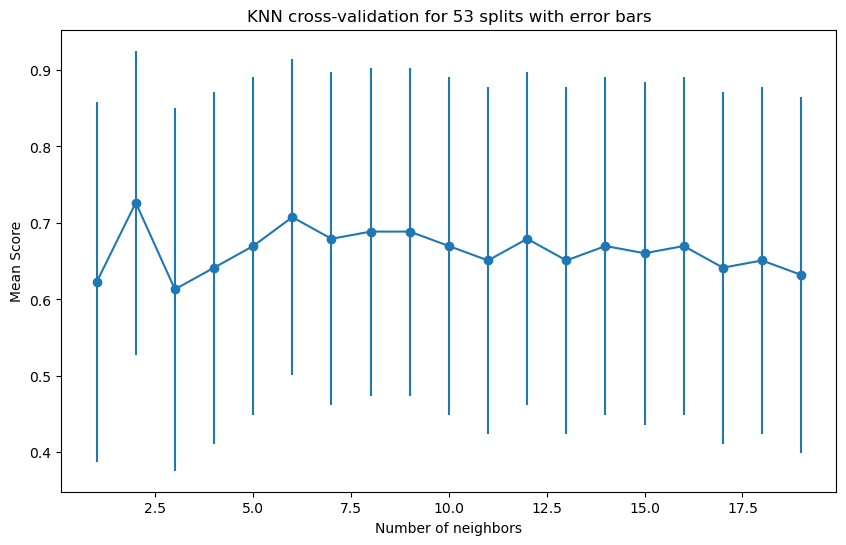

In [19]:
fold_scores = []
# define space to iterate over
space = np.arange(1,20)
# define folds
folds = LeaveOneOut()

for tr_idx, tu_idx in folds.split(X,y):
    hyper_scores = []
    for hyper in space:
        knn = KNeighborsClassifier(n_neighbors=hyper)
        knn.fit(X[tr_idx],y[tr_idx])
        score = knn.score(X[tu_idx], y[tu_idx])
        hyper_scores.append(score)
    fold_scores.append(hyper_scores)
fig, ax = plt.subplots(1,1,figsize=(10,6))

# ax.plot(space, np.mean(fold_scores, axis=0))
plt.errorbar(space,np.mean(fold_scores,axis=0),np.var(fold_scores,axis=0), fmt='-o')
ax.set_xlabel("Number of neighbors")
ax.set_ylabel("Mean Score")
plt.title(f"KNN cross-validation for {n_splits} splits with error bars")

print(f"Optimal number of neighbors: {space[np.argmax(np.mean(fold_scores, axis=0))]}")